In [1]:
# -*- coding: utf-8 -*-

# This is a report using the data from IQAASL.
# IQAASL was a project funded by the Swiss Confederation
# It produces a summary of litter survey results for a defined region.
# These charts serve as the models for the development of plagespropres.ch
# The data is gathered by volunteers.
# Please remember all copyrights apply, please give credit when applicable
# The repo is maintained by the community effective January 01, 2022
# There is ample opportunity to contribute, learn and teach
# contact dev@hammerdirt.ch

# Dies ist ein Bericht, der die Daten von IQAASL verwendet.
# IQAASL war ein von der Schweizerischen Eidgenossenschaft finanziertes Projekt.
# Es erstellt eine Zusammenfassung der Ergebnisse der Littering-Umfrage für eine bestimmte Region.
# Diese Grafiken dienten als Vorlage für die Entwicklung von plagespropres.ch.
# Die Daten werden von Freiwilligen gesammelt.
# Bitte denken Sie daran, dass alle Copyrights gelten, bitte geben Sie den Namen an, wenn zutreffend.
# Das Repo wird ab dem 01. Januar 2022 von der Community gepflegt.
# Es gibt reichlich Gelegenheit, etwas beizutragen, zu lernen und zu lehren.
# Kontakt dev@hammerdirt.ch

# Il s'agit d'un rapport utilisant les données de IQAASL.
# IQAASL était un projet financé par la Confédération suisse.
# Il produit un résumé des résultats de l'enquête sur les déchets sauvages pour une région définie.
# Ces tableaux ont servi de modèles pour le développement de plagespropres.ch
# Les données sont recueillies par des bénévoles.
# N'oubliez pas que tous les droits d'auteur s'appliquent, veuillez indiquer le crédit lorsque cela est possible.
# Le dépôt est maintenu par la communauté à partir du 1er janvier 2022.
# Il y a de nombreuses possibilités de contribuer, d'apprendre et d'enseigner.
# contact dev@hammerdirt.ch

# sys, file and nav packages:
import datetime as dt

# for date and month formats in french or german
import locale

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import seaborn as sns

# home brew utitilties
import resources.chart_kwargs as ck
import resources.sr_ut as sut

# images and display
from IPython.display import Markdown as md

# set the locale to the language desired
loc = locale.getlocale()
lang =  'de_CH.utf8'
locale.setlocale(locale.LC_ALL, lang)

# the date is in iso standard:
# d = "%Y-%m-%d"

# it gets changed to german format
g = "%d.%m.%Y"

# set some parameters:
start_date = "01.03.2020"
end_date ="31.05.2021"
start_end = [start_date, end_date]
a_fail_rate = 50
unit_label = "p/100 m"
a_color = "saddlebrown"

# colors for gradients
cmap2 = ck.cmap2
colors_palette = ck.colors_palette

# set the maps
bassin_map = "resources/maps/neunburgersee_scaled.jpeg"

# top level aggregation
top = "Alle Erhebungsgebiete"

# define the feature level and components
this_feature = {"slug":"bt", "name":"Neuenburgersee", "level":"water_name_slug"}

this_level = 'city'
this_bassin ="aare"
bassin_label = "Erhebungsgebiet Aare"

lakes_of_interest = ["neuenburgersee"]
# explanatory variables:
luse_exp =  list(sut.luse_ge.values())

# common aggregations
agg_pcs_quantity = {unit_label:"sum", "quantity":"sum"}
agg_pcs_median = {unit_label:"median", "quantity":"sum"}

# aggregation of dimensional data
agg_dims = {"total_w":"sum", "mac_plast_w":"sum", "area":"sum", "length":"sum"}

# columns needed
use_these_cols = ["loc_date" ,
                  "% to buildings",
                  "% to trans", 
                  "% to recreation",
                  "% to agg",
                  "% to woods",
                  "population",
                  this_level,
                  "streets km",
                  "intersects",
                  "length",
                  "groupname",
                  "code"
                 ]

# get your data:
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
dfDims = pd.read_csv("resources/corrected_dims.csv")

# set the index of the beach data to location slug
dfBeaches.set_index("slug", inplace=True)

# make a map to city names
city_map = dfBeaches.city

# map water_name_slug to water_name
wname_wname = dfBeaches[["water_name_slug","water_name"]].reset_index(drop=True).drop_duplicates().set_index("water_name_slug")

dfCodes.set_index("code", inplace=True)

# language specific
# importing german code descriptions
de_codes = pd.read_csv("resources/codes_german_Version_1.csv")
de_codes.set_index("code", inplace=True)

for x in dfCodes.index:
    dfCodes.loc[x, "description"] = de_codes.loc[x, "german"]

# there are long code descriptions that may need to be shortened for display
codes_to_change = [
    ["G704", "description", "Seilbahnbürste"],
    ["Gfrags", "description", "Fragmentierte Kunststoffstücke"],
    ["G30", "description", "Snack-Verpackungen"],
    ["G124", "description", "Kunststoff-oder Schaumstoffprodukte"],
    ["G87", "description", "Abdeckklebeband/Verpackungsklebeband"],
    ["G178","description","Flaschenverschlüsse aus Metall"],
    ["G3","description","Einkaufstaschen, Shoppingtaschen"],
    ["G33", "description", "Einwegartikel; Tassen/Becher & Deckel"],
    ["G31", "description", "Schleckstengel, Stengel von Lutscher"],
    ["G211", "description", "Sonstiges medizinisches Material"],
    ["G904", "description", "Feuerwerkskörper; Raketenkappen"],
    ["G940", "description", "Schaumstoff EVA (flexibler Kunststoff)"]
]

# apply changes
for x in codes_to_change:
    dfCodes = sut.shorten_the_value(x, dfCodes)

# the surveyor designated the object as aluminum instead of metal
dfCodes.loc["G708", "material"] = "Metal"

# translate the material column
dfCodes["material"] = dfCodes.material.map(lambda x: sut.mat_ge[x]) 

# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code materials
code_material_map = dfCodes.material

(neuenburgerseede)=
# Neuenburgersee

<a href="neuenburgersee.html"> English </a>

*__Unten:__ Karte des Erhebungsgebiets März 2020 - Mai 2021. Durchmesser der Punktsymbole = das mittlere Erhebungsergebnis in gefundene Abfallobjekte pro 100 Meter (p/100m).*

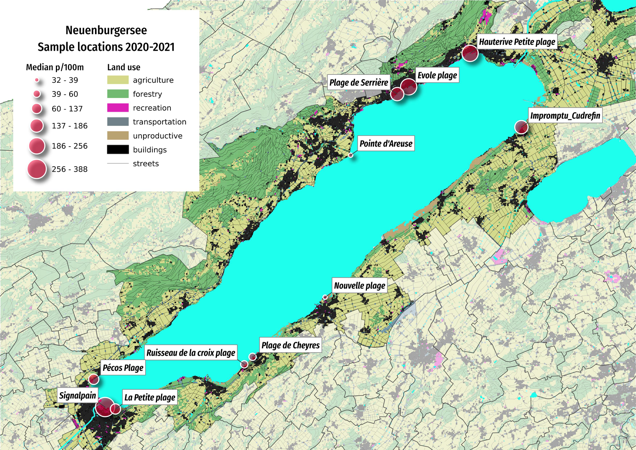

In [2]:
sut.display_image_ipython(bassin_map, thumb=(800,450))

## Erhebungsorte

In [3]:
# this is the data before the expanded foams and fragmented plastics are aggregated to Gfrags and Gfoams
before_agg = pd.read_csv("resources/checked_before_agg_sdata_eos_2020_21.csv")

# this is the aggregated survey data that is being used
# a_data is all the data in the survey period
a_data = pd.read_csv(F"resources/checked_sdata_eos_2020_21.csv")

# apply local date configuration
a_data["date"] = pd.to_datetime(a_data.date)
a_data["date"] = a_data["date"].dt.strftime(g)
a_data["date"] = pd.to_datetime(a_data["date"], format=g)

# rename the code groups and columns to local
a_data["groupname"] = a_data["groupname"].map(lambda x: sut.group_names_de[x])
# rename unit labels to FOEN spec
a_data.rename(columns={"p/100m": unit_label}, inplace=True)
a_data.rename(columns=sut.luse_ge, inplace=True)

# the data for this report
fd = sut.feature_data(a_data, this_feature["level"], these_features=lakes_of_interest)

# cumulative statistics for each code
code_totals = sut.the_aggregated_object_values(fd, agg=agg_pcs_median, description_map=code_description_map, material_map=code_material_map)    

# daily survey totals
dt_all = fd.groupby(["loc_date","location",this_level, "date"], as_index=False).agg(agg_pcs_quantity )

# the materials table
fd_mat_totals = sut.the_ratio_object_to_total(code_totals)

# summary statistics, nsamples, nmunicipalities, names of citys, population
t = sut.make_table_values(fd, col_nunique=["location", "loc_date", "city"], col_sum=["quantity"], col_median=[])

# make a map to the population values for each survey location/city
fd_pop_map = dfBeaches.loc[fd.location.unique()][["city", "population"]].copy()
fd_pop_map.drop_duplicates(inplace=True)

# update t with the population data
t.update(sut.make_table_values(fd_pop_map, col_nunique=["city"], col_sum=["population"], col_median=[]))

# update t with the list of locations from fd
t.update({"locations":fd.location.unique()})

# make a map to the population values for each survey location/city
fd_pop_map = dfBeaches.loc[fd.location.unique()][["city", "population"]].copy()
fd_pop_map.drop_duplicates(inplace=True)

# number of cities
fd_n_munis = len(fd_pop_map.index)

# total population
fd_effected_population = fd_pop_map.sum()

# join the strings into comma separated list
obj_string = locale.format_string('%d', int(t["quantity"]), grouping=True)
surv_string = locale.format_string('%d', int(t["loc_date"]), grouping=True)
pop_string = locale.format_string('%d', int(t["population"]), grouping=True)

# make strings
date_quantity_context = F"Für den Zeitraum zwischen {start_date[3:]} und {end_date[3:]}, wurden im Rahmen von {surv_string} Datenerhebungen insgesamt {obj_string } Objekte entfernt und identifiziert."
geo_context = F"Die Ergebnisse des {this_feature['name']} umfassen {t['location']} Orte,  {t['city']} Gemeinden und eine Gesamtbevölkerung von etwa {pop_string} Einwohnern."
munis_joined = ", ".join(sorted(fd_pop_map["city"]))

# put that all together:
lake_string = F"""
{date_quantity_context} {geo_context }

*Die Gemeinden in diesem Bericht:*\n\n >{munis_joined}
"""
md(lake_string)


Für den Zeitraum zwischen 03.2020 und 05.2021, wurden im Rahmen von 44 Datenerhebungen insgesamt 4’825 Objekte entfernt und identifiziert. Die Ergebnisse des Neuenburgersee umfassen 11 Orte,  8 Gemeinden und eine Gesamtbevölkerung von etwa 89’449 Einwohnern.

*Die Gemeinden in diesem Bericht:*

 >Boudry, Cheyres-Châbles, Cudrefin, Estavayer, Grandson, Hauterive (NE), Neuchâtel, Yverdon-les-Bains


### Kumulative Gesamtmengen nach Gemeinden

In [4]:
dims_parameters = dict(this_level=this_level, 
                       locations=fd.location.unique(), 
                       start_end=start_end, 
                       city_map=city_map, 
                       agg_dims=agg_dims)

dims_table = sut.gather_dimensional_data(dfDims, **dims_parameters)

# a map of total quantity for each component
q_map = fd.groupby(this_level).quantity.sum()

# collect the number of samples from the survey total data:
for name in dims_table.index:
    dims_table.loc[name, "samples"] = fd[fd[this_level] == name].loc_date.nunique()
    dims_table.loc[name, "quantity"] = q_map[name]

# get the sum of all survey areas
dims_table.loc[this_feature["name"]]= dims_table.sum(numeric_only=True, axis=0)

# for display
dims_table.sort_values(by=["quantity"], ascending=False, inplace=True)
dims_table.rename(columns={"samples":"Erhebungen","quantity":"Objekte", "total_w":"Gesamt-kg", "mac_plast_w":"kg Plastik", "area":"m²", "length":"Meter"}, inplace=True)

# format kilos
dims_table["kg Plastik"] = dims_table["kg Plastik"]/1000
dims_table[["m²", "Meter", "Erhebungen", "Objekte"]] = dims_table[["m²", "Meter", "Erhebungen", "Objekte"]].applymap(lambda x: f"{locale.format_string('%d', int(x), grouping=True)}")
dims_table[["kg Plastik", "Gesamt-kg"]] = dims_table[["kg Plastik", "Gesamt-kg"]].applymap(lambda x: "{:.2f}".format(x))

# figure caption
agg_caption = F"""
*__Unten:__ {this_feature["name"]}: kumulierten Gewichte und Masse für die Gemeinden*
"""
md(agg_caption)


*__Unten:__ Neuenburgersee: kumulierten Gewichte und Masse für die Gemeinden*


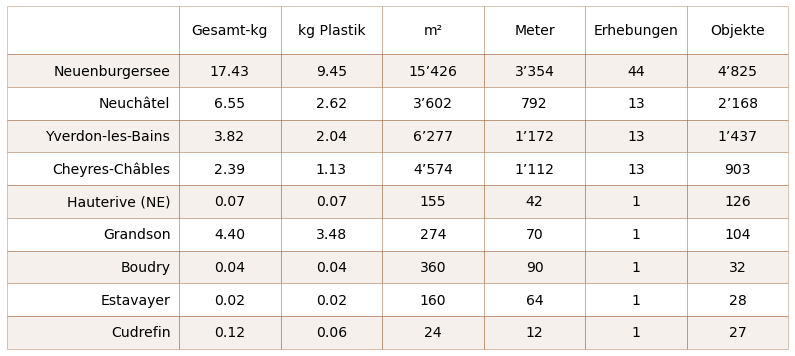

In [5]:
# make table
data = dims_table.reset_index()
colLabels = data.columns

fig, ax = plt.subplots(figsize=(len(colLabels)*2,len(data)*.7))

sut.hide_spines_ticks_grids(ax)
table_one = sut.make_a_table(ax, data.values, colLabels=colLabels, a_color=a_color)
table_one.get_celld()[(0,0)].get_text().set_text(" ")

plt.show()
plt.tight_layout()
plt.close()

### Verteilung der Erhebungsergebnisse

In [6]:
# the feature surveys to chart
fd_dindex = dt_all.set_index("date")

# all the other surveys
ots = dict(level_to_exclude=this_feature["level"], components_to_exclude=fd[this_feature["level"]].unique())
dts_date = sut.the_other_surveys(a_data, **ots)

# group the outher surveys by date and total pcs_m
ots_params = dict(agg_this = {unit_label:"sum"}, these_columns = ["loc_date","date"])
dts_date = sut.group_these_columns(dts_date, **ots_params)

# get the monthly or quarterly results for the feature
resample_plot, rate = sut.quarterly_or_monthly_values(fd_dindex , this_feature["name"], vals=unit_label, quarterly=["ticino"])    

# scale the chart as needed to accomodate for extreme values
y_lim = 96
y_limit = np.percentile(dts_date[unit_label], y_lim)

# label for the chart that alerts to the scale
not_included = F"Werte grösser als {round(y_limit, 1)} {unit_label} {y_lim}% nicht gezeigt."

# figure caption
chart_notes = F"""
*__Links:__ {this_feature['name']}, {start_date[3:]} bis {end_date[3:]}, n={t["loc_date"]}. {not_included} __Rechts:__ {this_feature['name']}  empirische kumulative Verteilung der Erhebungsergebnisse.*
"""
md(chart_notes )


*__Links:__ Neuenburgersee, 03.2020 bis 05.2021, n=44. Werte grösser als 1729.0 p/100 m 96% nicht gezeigt. __Rechts:__ Neuenburgersee  empirische kumulative Verteilung der Erhebungsergebnisse.*


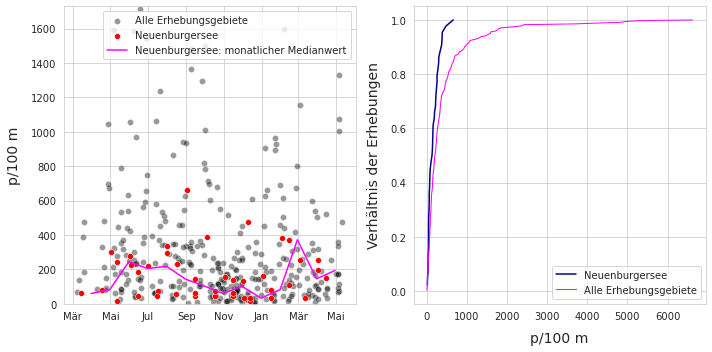

In [7]:
# months locator, can be confusing
# https://matplotlib.org/stable/api/dates_api.html
# months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter("%b")
days = mdates.DayLocator(interval=7)
sns.set_style("whitegrid")
fig, axs = plt.subplots(1,2, figsize=(10,5))

# the survey totals by day
ax = axs[0]

# feature surveys
sns.scatterplot(data=dts_date, x=dts_date.index, y=unit_label, label=top, color="black", alpha=0.4,  ax=ax)

# all other surveys
sns.scatterplot(data=fd_dindex, x=fd_dindex.index, y=unit_label, label=this_feature["name"], color="red", s=34, ec="white", ax=ax)

# monthly or quaterly plot
sns.lineplot(data=resample_plot, x=resample_plot.index, y=resample_plot, label=F"{this_feature['name']}: monatlicher Medianwert", color="magenta", ax=ax)

ax.set_ylim(0,y_limit )
ax.set_ylabel(unit_label, **ck.xlab_k14)

ax.set_xlabel("")
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(months_fmt)
ax.legend()

# the cumlative distributions:
axtwo = axs[1]

# the feature of interest
feature_ecd = ECDF(dt_all[unit_label].values)    
sns.lineplot(x=feature_ecd.x, y=feature_ecd.y, color="darkblue", ax=axtwo, label=this_feature["name"])

# the other features
other_features = ECDF(dts_date[unit_label].values)
sns.lineplot(x=other_features.x, y=other_features.y, color="magenta", label=top, linewidth=1, ax=axtwo)

axtwo.set_xlabel(unit_label, **ck.xlab_k14)
axtwo.set_ylabel("Verhältnis der Erhebungen", **ck.xlab_k14)

plt.tight_layout()
plt.show()

### Zusammenfassende Daten und Materialtypen

In [8]:
# figure caption
summary_of_survey_totals = F"""
*__Links:__ Zusammenfassung der Daten aller Erhebungen im {this_feature["name"]}. __Rechts:__ Gefundene Materialarten im {this_feature["name"]} und Prozentsatz deren Gesamtmenge.*
"""
md(summary_of_survey_totals)


*__Links:__ Zusammenfassung der Daten aller Erhebungen im Neuenburgersee. __Rechts:__ Gefundene Materialarten im Neuenburgersee und Prozentsatz deren Gesamtmenge.*


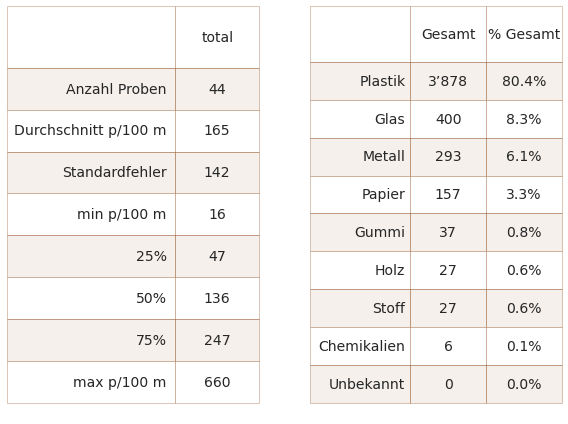

In [9]:
# get the basic statistics from pd.describe
cs = dt_all[unit_label].describe().round(2)

# change the names
csx = sut.change_series_index_labels(cs, sut.create_summary_table_index(unit_label, lang="DE"))

combined_summary = sut.fmt_combined_summary(csx, nf=[])

fd_mat_totals = sut.fmt_pct_of_total(fd_mat_totals)
fd_mat_totals = sut.make_string_format(fd_mat_totals)

# applly new column names for printing
cols_to_use = {"material":"Material","quantity":"Quantity", "% of total":"% of total"}
fd_mat_t = fd_mat_totals[cols_to_use.keys()].values

# make tables
fig, axs = plt.subplots(1,2, figsize=(8,6))

# summary table
# names for the table columns
a_col = [this_feature["name"], "total"]

axone = axs[0]
sut.hide_spines_ticks_grids(axone)

table_two = sut.make_a_table(axone, combined_summary,  colLabels=a_col, colWidths=[.5,.25,.25],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_two.get_celld()[(0,0)].get_text().set_text(" ")
table_two.set_fontsize(14)

# material table
axtwo = axs[1]
axtwo.set_xlabel(" ")
sut.hide_spines_ticks_grids(axtwo)

cols_to_use = {"material":"Material","quantity":"Gesamt", "% of total":"% Gesamt"}

table_three = sut.make_a_table(axtwo, fd_mat_t,  colLabels=list(cols_to_use.values()), colWidths=[.4, .3,.3],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_three.get_celld()[(0,0)].get_text().set_text(" ")

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.show()

## Die am häufigsten gefundenen Objekte

Die am häufigsten gefundenen Gegenständesind die zehn mengenmässig am meisten vorkommenden Objekte UND/ODER Objekte, die in mindestens 50% aller Datenerhebungen identifiziert wurden (fail-rate). 

In [10]:
# the top ten by quantity
most_abundant = code_totals.sort_values(by="quantity", ascending=False)[:10]

# the most common
most_common = code_totals[code_totals["fail rate"] >= a_fail_rate].sort_values(by="quantity", ascending=False)

# merge with most_common and drop duplicates
m_common = pd.concat([most_abundant, most_common]).drop_duplicates()

# get percent of total
m_common_percent_of_total = m_common.quantity.sum()/code_totals.quantity.sum()

# figure caption
rb_string = F"""
*__Unten:__ Häufigste Objekte im {this_feature["name"]}: fail-rate >/= 50% und/oder Top Ten nach Anzahl. Zusammengenommen machen die häufigsten Objekte {int(m_common_percent_of_total*100)}% aller gefundenen Objekte aus. Anmerkung: {unit_label} = Medianwert der Erhebung.*
"""
md(rb_string)


*__Unten:__ Häufigste Objekte im Neuenburgersee: fail-rate >/= 50% und/oder Top Ten nach Anzahl. Zusammengenommen machen die häufigsten Objekte 74% aller gefundenen Objekte aus. Anmerkung: p/100 m = Medianwert der Erhebung.*


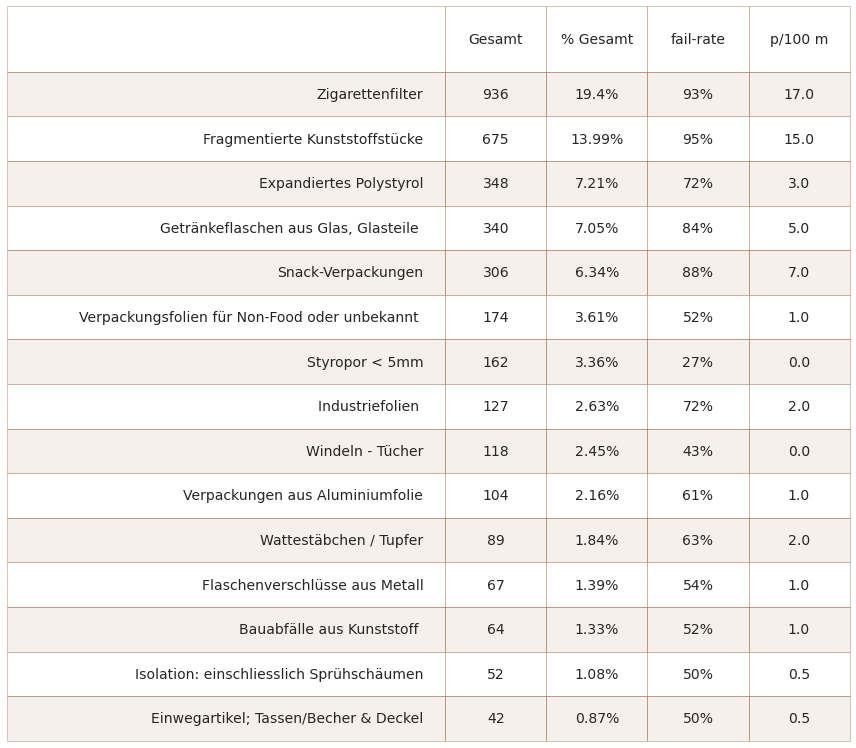

In [11]:
# format values for table
m_common["item"] = m_common.index.map(lambda x: code_description_map.loc[x])
m_common["% of total"] = m_common["% of total"].map(lambda x: F"{x}%")
m_common["quantity"] = m_common.quantity.map(lambda x: f"{locale.format_string('%d', x, grouping=True)}")
m_common["fail rate"] = m_common["fail rate"].map(lambda x: F"{x}%")
m_common[unit_label] = m_common[unit_label].map(lambda x: F"{round(x,1)}")

# final table data
cols_to_use = {"item":"Objekt","quantity":"Gesamt", "% of total":"% Gesamt", "fail rate":"fail-rate", unit_label:unit_label}
all_survey_areas = m_common[cols_to_use.keys()].values

fig, axs = plt.subplots(figsize=(12,len(m_common)*.7))

sut.hide_spines_ticks_grids(axs)

table_four = sut.make_a_table(axs, all_survey_areas,  colLabels=list(cols_to_use.values()), colWidths=[.52, .12,.12,.12, .12],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_four.get_celld()[(0,0)].get_text().set_text(" ")

plt.tight_layout()
plt.show()

plt.close()

### Die am häufigsten gefundenen Gegenständenach Gemeinden

In [12]:
rb_string = F"""
*__Unten:__ häufigste Objekte im {this_feature["name"]}: Median {unit_label}.*
"""
md(rb_string)


*__Unten:__ häufigste Objekte im Neuenburgersee: Median p/100 m.*


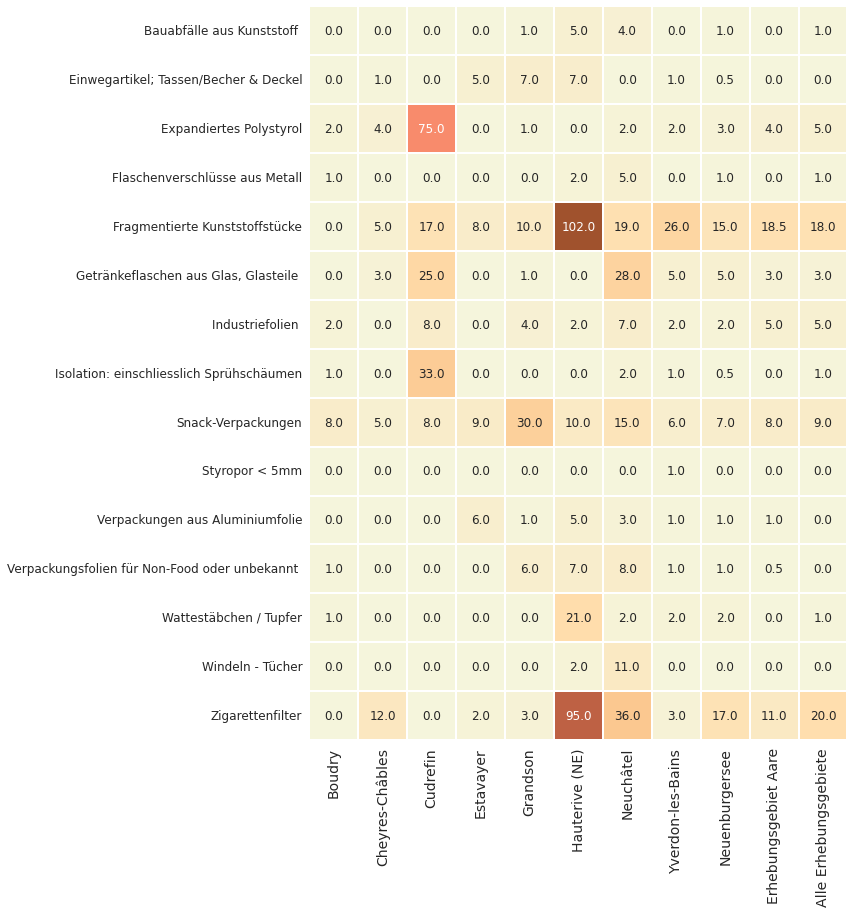

In [13]:
# aggregated survey totals for the most common codes for all the water features
m_common_st = fd[fd.code.isin(m_common.index)].groupby([this_level, "loc_date","code"], as_index=False).agg(agg_pcs_quantity)
m_common_ft = m_common_st.groupby([this_level, "code"], as_index=False)[unit_label].median()

# map the desctiption to the code
m_common_ft["item"] = m_common_ft.code.map(lambda x: code_description_map.loc[x])

# pivot that
m_c_p = m_common_ft[["item", this_level, unit_label]].pivot(columns=this_level, index="item")

# quash the hierarchal column index
m_c_p.columns = m_c_p.columns.get_level_values(1)

# the aggregated totals for the feature data
c = sut.aggregate_to_group_name(fd[fd.code.isin(m_common.index)], column="code", name=this_feature["name"], val="med", unit_label=unit_label)
m_c_p[this_feature["name"]]= sut.change_series_index_labels(c, {x:code_description_map.loc[x] for x in c.index})

# the aggregated totals of the survey area
c = sut.aggregate_to_group_name(a_data[(a_data.river_bassin == this_bassin)&(a_data.code.isin(m_common.index))], unit_label=unit_label, column="code", name=top, val="med")
m_c_p[bassin_label] = sut.change_series_index_labels(c, {x:code_description_map.loc[x] for x in c.index})

# the aggregated totals of all the data
c = sut.aggregate_to_group_name(a_data[(a_data.code.isin(m_common.index))], column="code", name=top, val="med", unit_label=unit_label)
m_c_p[top] = sut.change_series_index_labels(c, {x:code_description_map.loc[x] for x in c.index})

# chart that
fig, ax  = plt.subplots(figsize=(len(m_c_p.columns)*.9,len(m_c_p)*.9))
axone = ax

sns.heatmap(m_c_p, ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt=".1f", square=True, cbar=False, linewidth=.1, linecolor="white")
axone.set_xlabel("")
axone.set_ylabel("")
axone.tick_params(labelsize=14, which="both", axis="x")
axone.tick_params(labelsize=12, which="both", axis="y")

plt.setp(axone.get_xticklabels(), rotation=90)

plt.show()
plt.close()

### Die am häufigsten gefundenen Gegenständeim monatlichen Durchschnitt

In [14]:
# collect the survey results of the most common objects
m_common_m = fd[(fd.code.isin(m_common.index))].groupby(["loc_date", "date", "code", "groupname"], as_index=False).agg(agg_pcs_quantity)
m_common_m.set_index("date", inplace=True)

# set the order of the chart, group the codes by groupname columns
an_order = m_common_m.groupby(["code", "groupname"], as_index=False).quantity.sum().sort_values(by="groupname")["code"].values

# a manager dict for the monthly results of each code
mgr = {}

# get the monhtly results for each code:
for a_group in an_order:
    # resample by month
    a_plot = m_common_m[(m_common_m.code==a_group)][unit_label].resample("M").mean().fillna(0)
    this_group = {a_group:a_plot}
    mgr.update(this_group)

monthly_mc = F"""
*__Unten:__ {this_feature["name"]}, monatliche Durchschnittsergebnisse {unit_label}.*
"""
md(monthly_mc)


*__Unten:__ Neuenburgersee, monatliche Durchschnittsergebnisse p/100 m.*


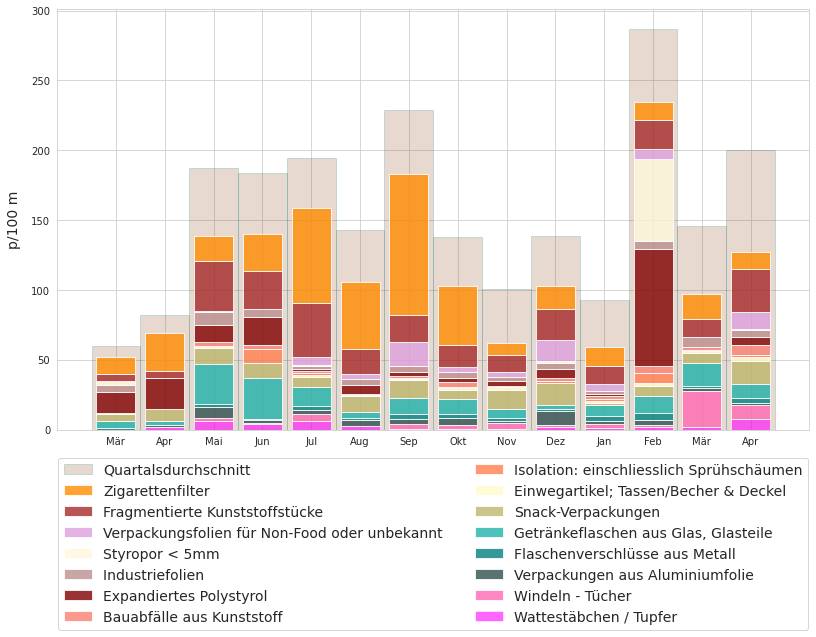

In [15]:
# convenience function to lable x axis
def new_month(x):
    if x <= 11:
        this_month = x
    else:
        this_month=x-12    
    return this_month

fig, ax = plt.subplots(figsize=(12,9))

# define a bottom
bottom = [0]*len(mgr["G27"])

# the monhtly survey average for all objects and locations
monthly_fd = fd.groupby(["loc_date", "date"], as_index=False).agg(agg_pcs_quantity)
monthly_fd.set_index("date", inplace=True)
m_fd = monthly_fd[unit_label].resample("M").mean().fillna(0)

# define the xaxis
this_x = [i for i,x in  enumerate(m_fd.index)]

# plot the monthly total survey average
ax.bar(this_x, m_fd.to_numpy(), color=a_color, alpha=0.2, linewidth=1, edgecolor="teal", width=1, label="Monthly survey average") 

# plot the monthly survey average of the most common objects
for i, a_group in enumerate(an_order): 
    
    # define the axis
    this_x = [i for i,x in  enumerate(mgr[a_group].index)]
    
    # collect the month
    this_month = [x.month for i,x in enumerate(mgr[a_group].index)]
    
    # if i == 0 laydown the first bars
    if i == 0:
        ax.bar(this_x, mgr[a_group].to_numpy(), label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.6 ) 
    
    # else use the previous results to define the bottom
    else:
        bottom += mgr[an_order[i-1]].to_numpy()        
        ax.bar(this_x, mgr[a_group].to_numpy(), bottom=bottom, label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.8)
        
# collect the handles and labels from the legend
handles, labels = ax.get_legend_handles_labels()

# set the location of the x ticks
ax.xaxis.set_major_locator(ticker.FixedLocator([i for i in np.arange(len(this_x))]))
ax.set_ylabel(unit_label, **ck.xlab_k14)

#label the xticks by month
axisticks = ax.get_xticks()
labelsx = [sut.months_de[new_month(x-1)] for x in  this_month]
plt.xticks(ticks=axisticks, labels=labelsx)

# make the legend
# swap out codes for descriptions
new_labels = [code_description_map.loc[x] for x in labels[1:]]
new_labels = new_labels[::-1]

# insert a label for the monthly average
new_labels.insert(0,"Quartalsdurchschnitt")
handles = [handles[0], *handles[1:][::-1]]
    
plt.legend(handles=handles, labels=new_labels, bbox_to_anchor=(.5, -.05), loc="upper center",  ncol=2, fontsize=14)
plt.tight_layout()
plt.show()

## Verwendungszweck der gefundenen Objekte 

Die Nutzungsart basiert auf der Verwendung des Objekts, bevor es weggeworfen wurde, oder auf der Artikelbeschreibung, wenn die ursprüngliche Verwendung unbestimmt ist. Identifizierte Objekte werden einer der 260 vordefinierten Kategorien zugeordnet. Die Kategorien werden je nach Verwendung oder Artikelbeschreibung gruppiert. 

*  **Abwasser:** Gegenstände, die aus Kläranlagen freigesetzt werden, einschliesslich Gegenstände, die wahrscheinlich über die Toilette entsorgt werden   
*  **Mikroplastik (< 5 mm):** fragmentierte Kunststoffe und Kunststoffharze aus der Vorproduktion
*  **Infrastruktur:** Artikel im Zusammenhang mit dem Bau und der Instandhaltung von Gebäuden, Strassen und der Wasser-/Stromversorgung  
*  **Essen und Trinken:** alle Materialien, die mit dem Konsum von Essen und Trinken in Zusammenhang stehen
*  **Landwirtschaft:** z. B. für Mulch und Reihenabdeckungen, Gewächshäuser, Bodenbegasung, Ballenverpackungen. Einschliesslich Hartkunststoffe für landwirtschaftliche Zäune, Blumentöpfe usw. 
*  **Tabakwaren:** hauptsächlich Zigarettenfilter, einschliesslich aller mit dem Rauchen verbundenen Materialien 
*  **Freizeit und Erholung:** Objekte, die mit Sport und Freizeit zu tun haben, z. B. Angeln, Jagen, Wandern usw. 
*  **Verpackungen ausser Lebensmittel und Getränke:** Verpackungsmaterial, das nicht lebensmittel-, getränke- oder tabakbezogen ist
*  **Plastikfragmente:** Plastikteile unbestimmter Herkunft oder Verwendung  
*  **Persönliche Gegenstände:** Accessoires, Hygieneartikel und Kleidung 

Im Anhang finden Sie die vollständige Liste der identifizierten Objekte, einschliesslich Beschreibungen und Gruppenklassifizierung. Der Abschnitt [Codegruppen](codegroupsde) beschreibt jede Codegruppe im Detail und bietet eine umfassende Liste aller Objekte in einer Gruppe. 

In [16]:
cg_poft = F"""
<br></br>
*__Unten:__ Verwendungszweck oder Beschreibung der identifizierten Objekte in % der Gesamtzahl nach Gemeinden im {this_feature["name"]}. Fragmentierte Objekte, die nicht eindeutig identifiziert werden können, werden weiterhin nach ihrer Grösse klassifiziert.*
"""
md(cg_poft)


<br></br>
*__Unten:__ Verwendungszweck oder Beschreibung der identifizierten Objekte in % der Gesamtzahl nach Gemeinden im Neuenburgersee. Fragmentierte Objekte, die nicht eindeutig identifiziert werden können, werden weiterhin nach ihrer Grösse klassifiziert.*


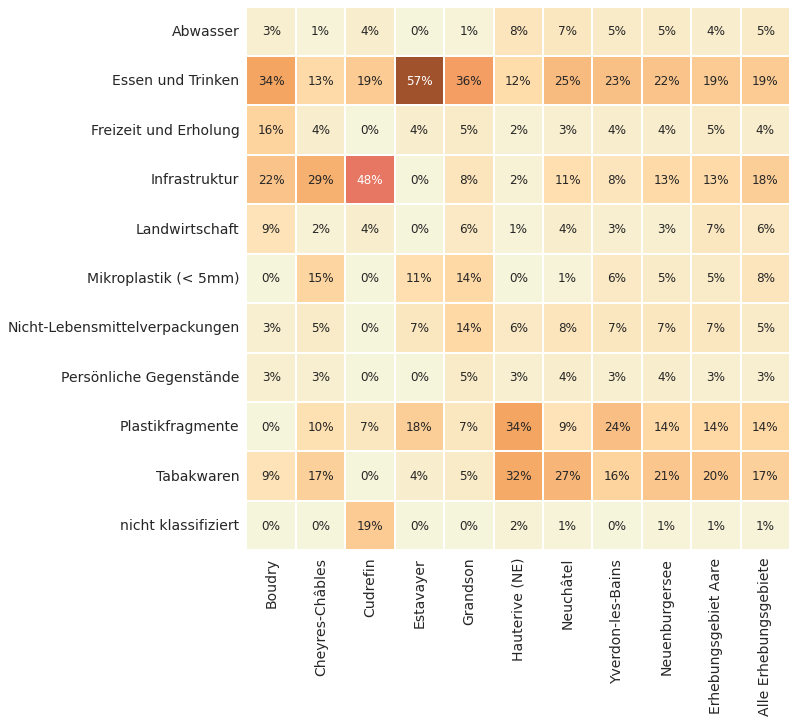

In [17]:
# code groups resluts aggregated by survey
groups = ["loc_date","groupname"]
cg_t = fd.groupby([this_level,*groups], as_index=False).agg(agg_pcs_quantity)

# the total per water feature
cg_tq = cg_t.groupby(this_level).quantity.sum()

# get the fail rates for each group per survey
cg_t["fail"]=False
cg_t["fail"] = cg_t.quantity.where(lambda x: x == 0, True)

# aggregate all that for each municipality
agg_this = {unit_label:"median", "quantity":"sum", "fail":"sum", "loc_date":"nunique"} 
cg_t = cg_t.groupby([this_level, "groupname"], as_index=False).agg(agg_this)

# assign survey area total to each record
for a_feature in cg_tq.index:
    cg_t.loc[cg_t[this_level] == a_feature, "f_total"] = cg_tq.loc[a_feature]

# get the percent of total for each group for each survey area
cg_t["pt"] = (cg_t.quantity/cg_t.f_total).round(2)

# pivot that
data_table = cg_t.pivot(columns=this_level, index="groupname", values="pt")

# aggregated values for the lake
data_table[this_feature["name"]]= sut.aggregate_to_group_name(fd, unit_label=unit_label, column="groupname", name=bassin_label, val="pt")

# repeat for the survey area
data_table[bassin_label] = sut.aggregate_to_group_name(a_data[a_data.river_bassin == this_bassin], unit_label=unit_label, column="groupname", name=bassin_label, val="pt")

# repeat for all the data
data_table[top] = sut.aggregate_to_group_name(a_data, unit_label=unit_label, column="groupname", name=top, val="pt")

data = data_table
# data.rename(columns={x:wname_wname.loc[x][0] for x in data.columns[:-2]}, inplace=True)

fig, ax = plt.subplots(figsize=(10,10))

axone = ax
sns.heatmap(data , ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, cbar=False, fmt=".0%", linewidth=.1, square=True, linecolor="white")

axone.set_ylabel("")
axone.set_xlabel("")
axone.tick_params(labelsize=14, which="both", axis="both", labeltop=False, labelbottom=True)

plt.setp(axone.get_xticklabels(), rotation=90, fontsize=14)
plt.setp(axone.get_yticklabels(), rotation=0, fontsize=14)

plt.show()

In [18]:
cg_medpcm = F"""
<br></br>
*__Unten:__ Verwendungszweck der gefundenen Objekte Median {unit_label} im {this_feature["name"]}. Fragmentierte Objekte, die nicht eindeutig identifiziert werden können, werden weiterhin nach ihrer Grösse klassifiziert.*
"""
md(cg_medpcm)


<br></br>
*__Unten:__ Verwendungszweck der gefundenen Objekte Median p/100 m im Neuenburgersee. Fragmentierte Objekte, die nicht eindeutig identifiziert werden können, werden weiterhin nach ihrer Grösse klassifiziert.*


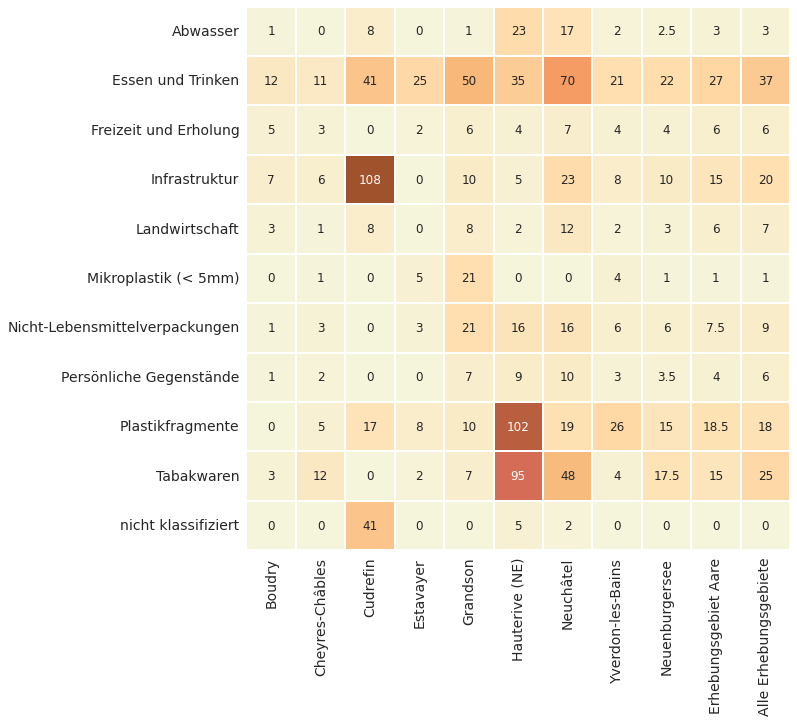

In [19]:
# median p/50m of all the water features
data_table = cg_t.pivot(columns=this_level, index="groupname", values=unit_label)

# aggregated values for the lake
data_table[this_feature["name"]]= sut.aggregate_to_group_name(fd, unit_label=unit_label, column="groupname", name=bassin_label, val="med")

# the survey area columns
data_table[bassin_label] = sut.aggregate_to_group_name(a_data[a_data.river_bassin == this_bassin], unit_label=unit_label, column="groupname", name=bassin_label, val="med")

# column for all the surveys
data_table[top] = sut.aggregate_to_group_name(a_data, unit_label=unit_label, column="groupname", name=top, val="med")

# merge with data_table
data = data_table

fig, ax = plt.subplots(figsize=(10,10))

axone = ax
sns.heatmap(data , ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt="g", cbar=False, linewidth=.1, square=True, linecolor="white")

axone.set_xlabel("")
axone.set_ylabel("")
axone.tick_params(labelsize=14, which="both", axis="both", labeltop=False, labelbottom=True)

plt.setp(axone.get_xticklabels(), rotation=90, fontsize=14)
plt.setp(axone.get_yticklabels(), rotation=0, fontsize=14)

plt.show()

## Anhang

### Schaumstoffe und Kunststoffe nach Grösse 

Die folgende Tabelle enthält die Komponenten "Gfoam" und "Gfrags", die für die Analyse gruppiert wurden. Objekte, die als Schaumstoffe gekennzeichnet sind, werden als Gfoam gruppiert und umfassen alle geschäumten Polystyrol-Kunststoffe > 0,5 cm.  Kunststoffteile und Objekte aus kombinierten Kunststoff- und Schaumstoffmaterialien > 0,5 cm werden für die Analyse als Gfrags gruppiert.

In [20]:
frag_foams = F"""
*__Unten:__ Fragmentierte und geschäumte Kunststoffe nach Grösse im {this_feature["name"]}, Median p/100m, Anzahl der gefundenen Stücke und Prozent der Gesamtmenge.*
"""
md(frag_foams)


*__Unten:__ Fragmentierte und geschäumte Kunststoffe nach Grösse im Neuenburgersee, Median p/100m, Anzahl der gefundenen Stücke und Prozent der Gesamtmenge.*


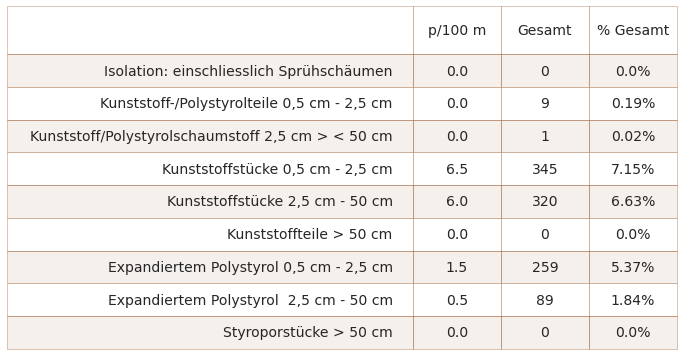

In [21]:
# collect the data before aggregating foams for all locations in the survey area

# the codes for the foams
some_foams = ["G81", "G82", "G83", "G74"]

# the codes for the fragmented plastics
before_agg.rename(columns={"p/100m": unit_label}, inplace=True)
some_frag_plas = list(before_agg[before_agg.groupname == "plastic pieces"].code.unique())

# aggregate all the codes by loc_date and get the total quantity and the median pcs/m
fd_frags_foams = before_agg[(before_agg.code.isin([*some_frag_plas, *some_foams]))&(before_agg.location.isin(t["locations"]))].groupby(["loc_date","code"], as_index=False).agg(agg_pcs_quantity)
fd_frags_foams = fd_frags_foams.groupby("code").agg(agg_pcs_median)

# add code description and format for printing
fd_frags_foams["item"] = fd_frags_foams.index.map(lambda x: code_description_map.loc[x])
fd_frags_foams["% of total"] = (fd_frags_foams.quantity/fd.quantity.sum()*100).round(2)
fd_frags_foams["% of total"] = fd_frags_foams["% of total"].map(lambda x: F"{x}%")
fd_frags_foams["quantity"] = fd_frags_foams["quantity"].map(lambda x: f"{locale.format_string('%d', x, grouping=True)}")

# table data
data = fd_frags_foams[["item", unit_label, "quantity", "% of total"]]

data.rename(columns={"quantity":"Gesamt", "% of total":"% Gesamt" }, inplace=True)

fig, axs = plt.subplots(figsize=(12,len(data)*.7))
sut.hide_spines_ticks_grids(axs)

a_table = sut.make_a_table(axs, data.values,  colLabels=data.columns, colWidths=[.6, .13, .13, .13])
a_table.get_celld()[(0,0)].get_text().set_text(" ")

plt.show()
plt.tight_layout()
plt.close()

### Die Erhebungsorte

In [22]:
# display the survey locations

disp_columns = ["latitude", "longitude", "city"]
disp_beaches = dfBeaches.loc[t["locations"]][disp_columns]
disp_beaches.reset_index(inplace=True)
disp_beaches.rename(columns={"city":"stat", "slug":"standort"}, inplace=True)
disp_beaches.set_index("standort", inplace=True, drop=True)

disp_beaches

,latitude,longitude,stat
standort,,,
la-petite-plage,46.785054,6.656877,Yverdon-les-Bains
evole-plage,46.989477,6.923920,Neuchâtel
plage-de-serriere,46.984850,6.913450,Neuchâtel
plage-de-cheyres,46.818689,6.782256,Cheyres-Châbles
signalpain,46.786200,6.647360,Yverdon-les-Bains
pointe-dareuse,46.946190,6.870970,Boudry
pecos-plage,46.803590,6.636650,Grandson
nouvelle-plage,46.856646,6.848428,Estavayer
ruisseau-de-la-croix-plage,46.813920,6.774700,Cheyres-Châbles


### Inventar der Objekte

In [23]:
# display inventory
pd.set_option("display.max_rows", None)
locale.setlocale(locale.LC_ALL, loc)
complete_inventory = code_totals[code_totals.quantity>0][["item", "groupname", "quantity", "% of total","fail rate"]]
complete_inventory.rename(columns={"item":"Objekte", "groupname":"Gruppenname", "quantity":"Gesamt", "% of total":"% Gesamt", "fail rate":"fail rate" }, inplace=True)


complete_inventory.sort_values(by="Gesamt", ascending=False)

,Objekte,Gruppenname,Gesamt,% Gesamt,fail rate
code,,,,,
G27,Zigarettenfilter,Tabakwaren,936,19.40,93
Gfrags,Fragmentierte Kunststoffstücke,Plastikfragmente,675,13.99,95
Gfoam,Expandiertes Polystyrol,Infrastruktur,348,7.21,72
G200,"Getränkeflaschen aus Glas, Glasteile",Essen und Trinken,340,7.05,84
G30,Snack-Verpackungen,Essen und Trinken,306,6.34,88
G941,Verpackungsfolien für Non-Food oder unbekannt,Nicht-Lebensmittelverpackungen,174,3.61,52
G117,Styropor < 5mm,Mikroplastik (< 5mm),162,3.36,27
G67,Industriefolien,Landwirtschaft,127,2.63,72
G98,Windeln - Tücher,Abwasser,118,2.45,43
